In [71]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [72]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[0].device
    port_motor = ports[1].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM6
Порт 1: COM7
Для получения данных выбран порт - COM6
Для двигателя выбран порт - COM7


In [ ]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    revolutions = 26
    distance=1000/9
    speed=100
    command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

# Чтение данных с катушек в память контроллера
time.sleep(3)
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'
    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialline.flush()
time.sleep(11)

# Получение данных с выбранного порта в память компьютера
rawdata = None
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=47)) as serialData:
    # Read data from COM port
    command = 'S'
    # Send the command to the DataPort
    serialData.write(command.encode())
    # Get data
    rawdata = serialData.read(4194305)

In [ ]:
# Перевод данных из битов в целые числа
data = []
for num in range(0, 2097152, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    data.append(hi_byte*256+lo_byte)

encoder = []
for num in range(2097152, len(rawdata)-1, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    encoder.append(hi_byte*256+lo_byte)
df_raw = pd.DataFrame({'encoder' : encoder, 'data' : data})

# Фильтрация данных от дельта-шумов
window_size = 3
df_filtered = pd.DataFrame(columns=['data', 'encoder'])
df_filtered.data = medfilt(df_raw.data, kernel_size=window_size)[window_size*2:-window_size*2]
df_filtered.encoder = medfilt(df_raw.encoder, kernel_size=window_size)[window_size*2:-window_size*2]

# Отрезаем целое число периодов
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
start_idx = split_points[0]
end_idx = split_points[-1]
df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

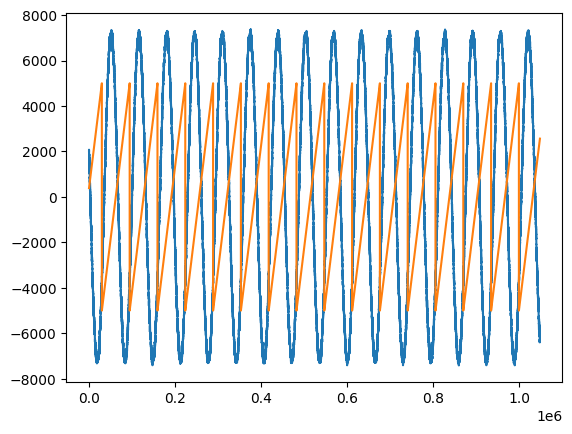

In [ ]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
# Добавим столбец, который идентифицирует периоды непрерывных значений encoder
df['period'] = (df['encoder'] != df['encoder'].shift()).cumsum()

# Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
df_res = df.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

df_res['integral'] = -1.0*df_res.data.cumsum()

# 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res.integral

df_res['deg'] = result.index/10000*360


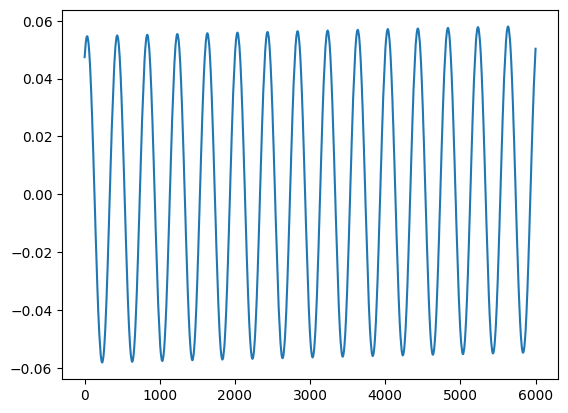

In [ ]:
# Шаг интегрирования по encoder
step = 25
# Создание интервалов
bins = range(0, len(df_filtered) + step, step)

# Находим индексы, где происходит переход с 9999 на 0
# split_points = df_filtered.index[(df_filtered['encoder'].shift(1) == 9999) & (df_filtered['encoder'] == 0)]
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]

# Добавляем начало и конец датасета
# split_points = [0] + split_points.tolist() + [len(df_filtered)]
# split_points = split_points.tolist()

# Создаем список разделенных датафреймов с группировкой по encoder
datasets = []
for i in range(len(split_points) - 1):
    start_idx = split_points[i]
    end_idx = split_points[i+1]
    dataset_part = df_filtered.iloc[start_idx:end_idx].copy()
    dataset_part.encoder = dataset_part.encoder + 10000 * i

    # Группировка по encoder и усреднение data
    dataset_part['bin'] = pd.cut(dataset_part['encoder'], bins=bins, right=False, labels=bins[:-1])
    grouped = dataset_part.groupby('bin', observed=True)['data'].sum()
    
    datasets.append(grouped)

df_encoder = pd.concat(datasets).reset_index()
df_encoder['integrated_data'] = -1*df_encoder['data'].cumsum()/32767*2.5*(10**-5) # 2.5/32767*10**-5 - коэф. для перевода в Вольты*сек

x = df_encoder.integrated_data.index.values
y = df_encoder.integrated_data.values

# Линейная регрессия для выделения тренда
coefficients = np.polyfit(x, y, 1)  # 1 - линейный тренд
df_encoder['trend'] = np.polyval(coefficients, x)

# Детрендированные данные
df_encoder['data'] = (df_encoder.integrated_data - df_encoder.trend) / 1144.8 # постоянная катушки
df_encoder['deg'] = df_encoder.index/10000/step*360

df = df_encoder.reindex(columns=['deg', 'data'])
plt.plot(df_encoder.data)

In [ ]:
import fastgoertzel as fg

f_amp, f_phase = fg.goertzel(df_res.volts.values, 1/10000)
# phase = phase*180/np.pi
print(f'Fast Goertzel Amp: {f_amp:}, {f_phase = :}')

In [ ]:
PT = 10000 # точек на период
N = len(df_res)-len(df_res)%PT # 150000 количество отсчетов
# omega0 = 2*np.pi/PT # угловая частота
k = int(N/PT) # номер гармоники
alpha = 2*np.cos(2*np.pi*k/N)

signal = 'volts'
df_res['s'] = 0.0

n = 0
df_res.loc[n, 's'] = df_res.loc[n, signal] + alpha*0 - 0
n = 1
df_res.loc[n, 's'] = df_res.loc[n, signal] + alpha*df_res.loc[n-1, 's'] - 0

for n in range(2, len(df_res)):
    df_res.loc[n, 's'] = df_res.loc[n, signal] + alpha*df_res.loc[n-1, 's'] - df_res.loc[n-2, 's']

F2 = df_res.loc[N-1, 's']
F3 = df_res.loc[N-2, 's']

real = F2*np.cos(2*np.pi*k/N)-F3
imag = F2*np.sin(2*np.pi*k/N)

s_amp = np.sqrt(real**2 + imag**2)*2/N 
s_phi = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

# amp = 1/1144.8 * amp # 2.5/32767 - Volts ; 1/96937 - sec ; 1/1144.8 - m

print(f'Slow Goertzel Amp: {s_amp:}, {s_phi = :.3f}')

In [ ]:
# Находим амплитуду из максимумов

# Локальные максимумы
local_maxima = argrelextrema(df_res.volts.values, np.greater, order=100)[0]
# Локальные минимумы
local_minima = argrelextrema(df_res.volts.values, np.less, order=100)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df_res['is_local_max'] = False
df_res['is_local_min'] = False

df_res.loc[local_maxima, 'is_local_max'] = True
df_res.loc[local_minima, 'is_local_min'] = True

# Извлечение экстремумов
maxima = df_res[df_res['is_local_max']]
minima = df_res[df_res['is_local_min']]

# Вычисляем средние значения
mean_max = maxima['data'].mean()
mean_min = minima['data'].mean()

# Разность средних
amplitude = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima['data'].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima['data'].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amplitude * 100  # в процентах

print(f"   Амплитуда = {amplitude:.3} ± {absolute_error:.2}")
print(f"   Относительная погрешность: {relative_error:.4f}%")

Найдено локальных максимумов: 15
Найдено локальных минимумов: 15
